This tutorial illustrates a simple usage of Loter for local ancestry inference.

## Table of Contents
* [I) Installation](#installation)
* [II) Quick overview](#loter_usage)
* [III) Running Loter from VCF Files](#vcf)


# I) Installation <a class="anchor" id="installation"></a>

To install Loter follow the procedure explained in the README.md file.
If you have already installed Loter, jump to [Loter usage](#loter_usage).

# II) Quick overview <a class="anchor" id='loter_usage'></a>

## a) Load Data <a  class="anchor" id='load_data'></a>

We use human haplotype data generated from the Hapmap dataset (see https://www.ncbi.nlm.nih.gov/probe/docs/projhapmap/). In particular, we use haplotype regarding the 50000 first SNPs from both copies of chromosome 1 for two different populations: 44 European individuals (CEU) and 50 African inviduals (YRI)

In [1]:
import os
import numpy as np

H_ceu = np.load(os.path.join(os.pardir, "data", "H_ceu.npy"))
H_yri = np.load(os.path.join(os.pardir, "data", "H_yri.npy"))

In [2]:
H_ceu.shape # 2*44 chromosomes and 50000 SNPs

(88, 50000)

In [3]:
H_yri.shape # 2*50 chromosomes and 50000 SNPs

(100, 50000)

## b) Create a simple synthetic admixed individual <a class="anchor" id='admixed'></a>

We create a very simple synthetic admixed individual from a mixture between CEU (European) and YRI (African) populations, a single generation ago, with a single recombination event.


In [4]:
H_adm = np.copy(H_ceu[:2])
pos_snp = 20000 #H_yri.shape[1] // 2
H_adm[:, pos_snp:] = H_yri[:2, pos_snp:]

In [5]:
H_adm.shape

(2, 50000)

## c) Run Loter <a class="anchor" id='run_loter'></a>

We exclude from the training set the 2 first individuals used to create the admixed individual.

In [6]:
import loter.locanc.local_ancestry as lc

res_loter = lc.loter_smooth([H_ceu[2:], H_yri[2:]], H_adm, num_threads=8) ## set the number of threads

## d) Visualize ancestry chunks <a class="anchor" id='plot_result'></a>

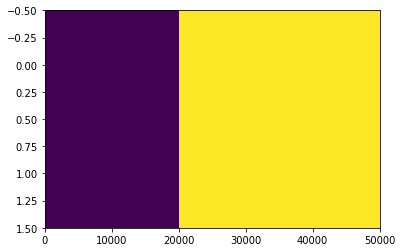

In [7]:
% matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(res_loter, interpolation='none', aspect='auto')

Where the switch appear in the result.

In [8]:
np.argwhere(np.diff(res_loter))

array([[    0, 19997],
       [    1, 19997]])

Notice you might find another result due to the stochastic nature of Loter.

# III) Running Loter from VCF Files <a class="anchor" id='vcf'></a>

To load a VCF, we use [scikit allel](https://scikit-allel.readthedocs.io/en/latest/#).

In [9]:
import allel
import numpy as np

`vcf2npy` convert a VCF File to a numpy matrix with 0, 1 and 2.

In [10]:
def vcf2npy(vcfpath):
    callset = allel.read_vcf(vcfpath)
    haplotypes_1 = callset['calldata/GT'][:,:,0]
    haplotypes_2 = callset['calldata/GT'][:,:,1]
    
    m, n = haplotypes_1.shape
    mat_haplo = np.empty((2*n, m))
    mat_haplo[::2] = haplotypes_1.T
    mat_haplo[1::2] = haplotypes_2.T
    
    return mat_haplo.astype(np.uint8)

These 3 files are the results of the phasing software [Beagle](https://faculty.washington.edu/browning/beagle/beagle.html).

In [11]:
ceu_hap = vcf2npy('../data/ceu.vcf')
yri_hap = vcf2npy('../data/yri.vcf')
mex_hap = vcf2npy('../data/mex.vcf')

Finally, we run Loter with default parameters.
We assume, in this example, that Mexicans (*MEX*) are the result of admixture between Europeans (*CEU*) and Africans (*YRI*).
This computation may take several minutes to complete.

`loter_smooth` takes two arguments:
- a list of ancestral haplotypes matrices. Its length is equal to the number of ancestral populations.
- a matrix of admixed haplotypes

and returns the origin of each SNP.

In [12]:
import loter.locanc.local_ancestry as lc

mex_admixed = lc.loter_smooth([ceu_hap, yri_hap], mex_hap, num_threads=8) ## set the number of threads

In [13]:
print(mex_admixed)

[[0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]
 ...
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 0 0 0]]


We display admixture chunks.
Chunks of zero correspond to CEU (first element of the list) and chunks of one correspond to YRI (second element of the list).

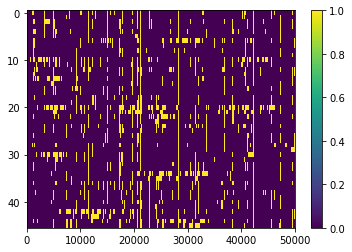

In [14]:
% matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(mex_admixed, interpolation='nearest', aspect='auto')
plt.colorbar()

Finally, we can save the result.
Each line correspond to an haplotype. The SNPs are space delimited.

In [20]:
np.savetxt("result_mex.txt", mex_admixed, fmt="%i")

## Dealing with more than 2 ancestral populations

In [15]:
import loter.locanc.local_ancestry as lc

res_impute, res_no_impute = lc.loter_local_ancestry([ceu_hap, yri_hap, mex_hap], mex_hap)

The result containing haplotypic ancestry can be found in the second variable 'res_no_impute'.
'res_no_impute[0]' contains the ancestry.
'res_no_impute[1]' contains the number of time that ancestry was picked.

'res_impute' contains the genotypic ancestry. The genotypic ancestry corresponds to the paired  haplotypic ancestries without order. For instance, if there are 3 ancestral populations, there are 6 possible ancestry values for genotypic ancestry.

Denoting by h1 and h2 the haplotypic ancestry at a locus, the mapping function is the following:
g: (h1, h2) -> (max(h1, h2) * (max(h1, h2) + 1))/2 + min(h1, h2)

For example, let's consider 3 populations:
* g((0, 0)) = (0 * 1)/2 + 0 = 0

* g((0, 1)) = g((1, 0)) = (0 * 1)/2 + 1 = 1

* g((1, 1)) = (1 * 2)/2 + 1 = 2

* g((2, 0)) = g((0, 2)) = (2 * 3)/2 + 0 = 3

* g((2, 1)) = g((1, 2)) = (2 * 3)/2 + 1 = 4

* g((2, 2)) = (2 * 3)/2 + 2 = 5

So genotypic ancestry compresses the pair information into one single number.
It is useful for the computation of the genotypic ancestry error rate.

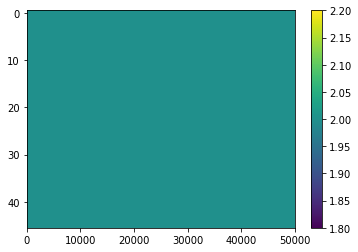

In [16]:
% matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(res_no_impute[0], interpolation='nearest', aspect='auto')
plt.colorbar()

In [17]:
res_no_impute[0]

array([[2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       ...,
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2]])

Not that it is not currently possible to account for phasing errors in Loter when there are more than two ancestral populations. Haplotypic length of ancestry tracts will be affected and should not be used when there are more than 2 ancestral populations. Other statistics at the scale of genotypes (mean ancestry in the population, mean ancestry per individual) are accurately inferred.

In [10]:
np.savetxt("result_3wayadmixture.txt", res_no_impute[0], fmt="%i")